In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob
import PIL.Image as Image

In [2]:
train_file = open('sample_train.txt', 'r') 
paths = train_file.readlines();

for i in range(0, len(paths)):
    paths[i] = paths[i].rstrip()
    
train_paths = []
for i in paths:
    train_paths.append([i.split(' ')[0], i.split(' ')[1]])
    
train_data = []
for i in train_paths:
    image = np.array(Image.open(i[0]).convert('L'), dtype='uint8')
    image = np.reshape(image, (256*256, 1))
    train_data.append([image, i[1]])

In [3]:
test_file = open('sample_test.txt', 'r') 
paths = test_file.readlines();

for i in range(0, len(paths)):
    paths[i] = paths[i].rstrip()
    
test_data = []

for i in paths:
    image = np.array(Image.open(i).convert('L'), dtype='uint8')
    image = np.reshape(image, (256*256, 1))
    test_data.append(image)

In [4]:
def read_images(path, sz=None):
    X = []
    for files in glob.glob(path + "/*.jpg"):
        image = np.array(Image.open(files).convert('L'), dtype='uint8')
        X.append(image)
    return X

def normalize(X, low, high):
    X = np.array(X)
    min_X, max_X = np.min(X), np.max(X)
    X = X - float(min_X)
    X = X / float((max_X - min_X))
    X = X * (high - low)
    X = X + low
    return np.array(X)

def asRowMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = []
    for i in range(0, len(X)):
        mat.append(np.reshape(X[i], (X[0].shape[0] * X[0].shape[0], )))
    return np.array(mat)

def subplot(title, images, rows, cols, subt = "subplot", subts = [], colormap='gray', ticks_visible=True):
    fig = plt.figure(figsize=(10,10))
    # main title
    fig.text(.5, .95, title, horizontalalignment='center') 
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows,cols,(i+1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)
        if len(subts) == len(images):
            plt.title("%s %s" % (subt, str(subts[i])), create_font('Tahoma',10))
        else:
            plt.title("%s %d" % (subt, (i+1)), create_font('Tahoma',10))
        plt.imshow(np.asarray(images[i]), cmap=colormap)
    plt.show()

def pca(X):
    [n,d] = X.shape
    mu = X.mean(axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
            
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return [eigenvalues, eigenvectors, mu]

def project(W, X, mu = None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X - mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y,W.T)
    return np.dot(Y, W.T) + mu

def weight_img(image, components):
    numEvs = components
    P = project(eig_vecs[:,0:numEvs], image.reshape(1,-1), mu)
    return P

def reconstruct_img(image):
    steps = [i for i in range(10, min(len(X), 320), 20)]
    E = []
    for i in range(len(steps)):
        numEvs = steps[i]
        P = project(eig_vecs[:,0:numEvs], image.reshape(1,-1), mu)
        R = reconstruct(eig_vecs[:,0:numEvs], P, mu)
        # reshape and append
        R = R.reshape(image.shape)
        E.append(normalize(R,0,255))
    return E, steps

def MSE(X, Y):
    m, n = X.shape
    error = 0
    for i in range(m):
        for j in range(n):
            error += (X[i, j] - Y[i, j])**2
    error /= (m * n)
    return error

In [5]:
X = read_images('./dataset')

In [6]:
[eig_val, eig_vecs, mu] = pca(asRowMatrix(X))
components = 32

In [7]:
Eig_face = []
for i in range(min(len(X), components)):
    e = eig_vecs[:,i].reshape(X[0].shape)
    Eig_face.append(normalize(e, 0, 255))

In [8]:
train_data_X = []
train_data_Y = []
for i in range(0, len(train_data)):
    train_data_X.append(weight_img(train_data[i][0], components).flatten())
    train_data_Y.append(train_data[i][1])
test_data_X = []
for i in range(0, len(test_data)):
    test_data_X.append(weight_img(test_data[i], components).flatten())

In [9]:
train_data_X = np.array(train_data_X)
train_data_Y = np.array(train_data_Y)
test_data_X = np.array(test_data_X)

In [10]:
def getLoss(w,x,y,lam):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss, grad

In [11]:
def create_lable(Y):
    l_dict = dict(zip(set(Y), range(len(Y))))
    return np.array([l_dict[x] for x in Y])

In [12]:
def oneHotIt(Y):
    n_values = np.max(Y) + 1
    return np.eye(n_values)[Y] 

In [13]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

In [14]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [15]:
x = train_data_X
y = create_lable(train_data_Y)
w = np.zeros([x.shape[1],len(np.unique(y))])
lam = 1
iterations = 10
learningRate = 1e-5
losses = []
for i in range(0,iterations):
    loss,grad = getLoss(w,x,y,lam)
    losses.append(loss)
    w = w - (learningRate * grad)
print(loss)

0.0007955993222191435


In [16]:
prob, prede = getProbsAndPreds(x)

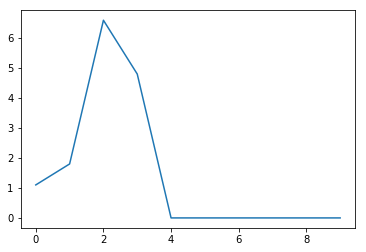

In [17]:
plt.plot(losses)